In [1]:
library(tidyverse)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



# 1. Non parametric test, 1 sample  - Signed Test

**Reference**: 
- <https://cran.r-project.org/web/packages/distributions3/vignettes/one-sample-sign-tests.html>
- <https://www.youtube.com/watch?v=MFIcCOTHFPo&list=PLIeGtxpvyG-IV0Yf8AyeMgmNkpFBxBJlh&index=2>

### 1.1 Derivation

In [2]:
# incomes are typically very skewed, so Z-test or T-test is not approriate
incomes <- c(8478, 21564, 36562, 176602, 9395, 18320, 50000, 2, 40298, 39, 10780, 2268583, 3404930)

Luckily, the sign test only requires independent samples for valid inference (as a consequence, it has been low power).

$H_0$: median = 50000   
$H_1$: median $\ne$ 50000

In [65]:
n <- sum(incomes != 50000)
plus_signs <- sum(incomes > 50000)
plus_signs

# 2 sided
binom.test(plus_signs, n, p = 0.5, alternative = "two.sided", conf.level = .95)

[1] 3


	Exact binomial test

data:  plus_signs and n
number of successes = 3, number of trials = 12, p-value = 0.146
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.05486064 0.57185846
sample estimates:
probability of success 
                  0.25 


### 1.2 Using R

In [4]:
# using wilcoxon 1 sample test
wilcox.test(incomes, mu = 50000)

Warning message in wilcox.test.default(incomes, mu = 50000):
"cannot compute exact p-value with zeroes"



	Wilcoxon signed rank test with continuity correction

data:  incomes
V = 33, p-value = 0.6661
alternative hypothesis: true location is not equal to 50000


### 1.3 Simulation for the sign test

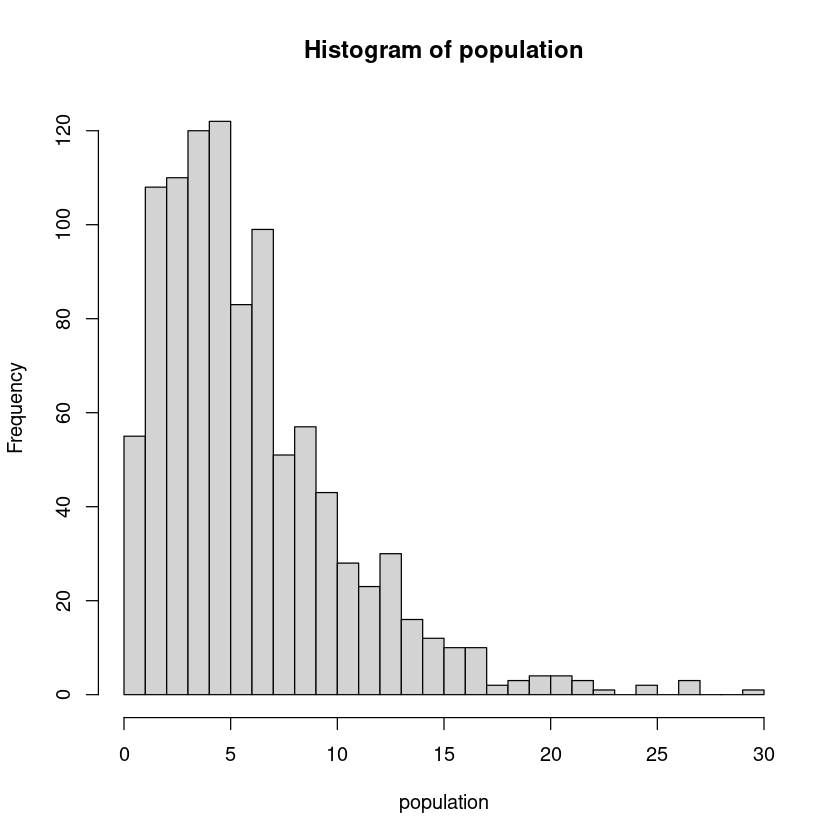

In [5]:
population <- rgamma(1000, shape = 2, scale = 3)
hist(population, breaks = 30)

In [6]:
population_median <- median(population)
population_median

[1] 4.878336

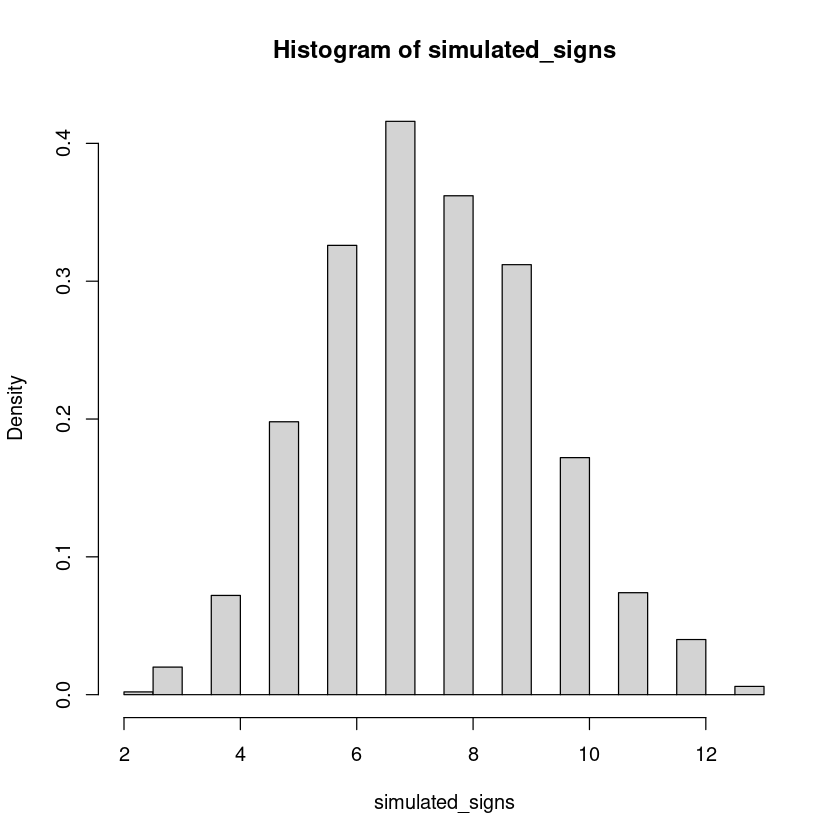

In [66]:
nsims <- 1000
sample_size <- 15
simulated_signs <- replicate(nsims, {
    sample_data <- sample(population, size = sample_size)
    plus_signs <- sum(sample_data > population_median)
    plus_signs
})

hist(simulated_signs, prob = T, breaks = 16)

# 2. Non parametric test, 2 independent samples  - Mann-Whitney U test (Wilcoxon Rank Sum test)

**Reference**:
- <https://www.youtube.com/watch?v=fEobVCV2TJE&list=PLIeGtxpvyG-IV0Yf8AyeMgmNkpFBxBJlh&index=3>

> **`wilcox.test`**

### 2.1 Derivation

$H_0: median_1 = median_2$ (there is no difference between 2 groups)   
$H_1: median_1 \ne median_2$ (there is a statistically significant difference between 2 groups)   
Significant level: $\alpha$ = 0.05

In [164]:
# Step 1: Place samples into 2 columns
scores <- tibble(
    group1 = c(5,8,4,4, 7,6,7,6,7,8,6,4,8,5,3,3,5,8,4,2,4,7,5,6,3),
    group2 = c(9, 8, 3, 4, 10,5,10,9,4,10,3,7,10,7,9,7,4,7,8,4,7,8,10,5,7)
) %>% 
# Step 2: stack the scores of 2 group into 1 column
pivot_longer(everything(), 
                   names_to = "group", 
                   values_to = "score", 
                   names_transform = list(group = parse_number))
scores

group,score
<dbl>,<dbl>
1,5
2,9
1,8
2,8
1,4
2,3
1,4
2,4
1,7


In [167]:
# step 3: rank the score using average rank
ranksum <- scores %>% mutate(ranking = rank(score, "average")) %>% 
# step 4: calculate rank sum for each group
group_by(group) %>% summarize(rank_sum = sum(ranking))

ranksum

`summarise()` ungrouping output (override with `.groups` argument)



group,rank_sum
<dbl>,<dbl>
1,514
2,761


In [170]:
# test statistic
w <- ranksum$rank_sum[1]
w

[1] 514

In [172]:
n1 <- sum(scores$group == 1)
n2 <- sum(scores$group == 2)

# sampling distribution
mu_w <- n1 * (n1 + n2 + 1) / 2
se_w <- sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

c(mean = mu_w, sd = se_w)

mean        sd 
637.50000  51.53882

In [173]:
# z score
z <- (w - mu_w) / se_w
z

[1] -2.396252

In [174]:
# p value
p.value <- 2 * pnorm(z)
p.value

[1] 0.0165637

p value < 0.05 so we reject $H_0$, we have strong evidence against the null hypothesis

### 2.2 Using R

> **`wilcox.test()`**

In [178]:
# this perform Man-Whiney U test, although the W is different from above
# because 1 use wilcoxon rank sum statistics
# 1 use U statistic
# p.value is closely the same
wilcox.test(score ~ group, data = scores, exact = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  score by group
W = 189, p-value = 0.01588
alternative hypothesis: true location shift is not equal to 0


### 2.3 Simulation for Mann-Whitney U test

In [134]:
set.seed(42)
nsims <- 1000
n1 <- 15
n2 <- 22
w <- replicate(nsims, {
    # sample from 2 distributions with the same median
    sample1 <- rgamma(n1, shape = 2, scale = 3)
    sample2 <- rgamma(n2, shape = 2, scale = 3)
    sample_frame <- tibble(group = as.factor(rep(c('A', 'B'), time = c(n1, n2))), value = c(sample1, sample2)) 
    # sum of rank for group A
    sample_frame %>% mutate(rank = rank(value, ties.method = "average")) %>% filter(group == "A") %>% pull(rank) %>% sum()
    #wilcox.test(value ~ group, data = sample_frame)$statistic %>% unname()
})

In [135]:
mean(w)
n1 * (n1 + n2 + 1) / 2

[1] 284.128

[1] 285

In [136]:
sd(w)
sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

[1] 31.95407

[1] 32.32646

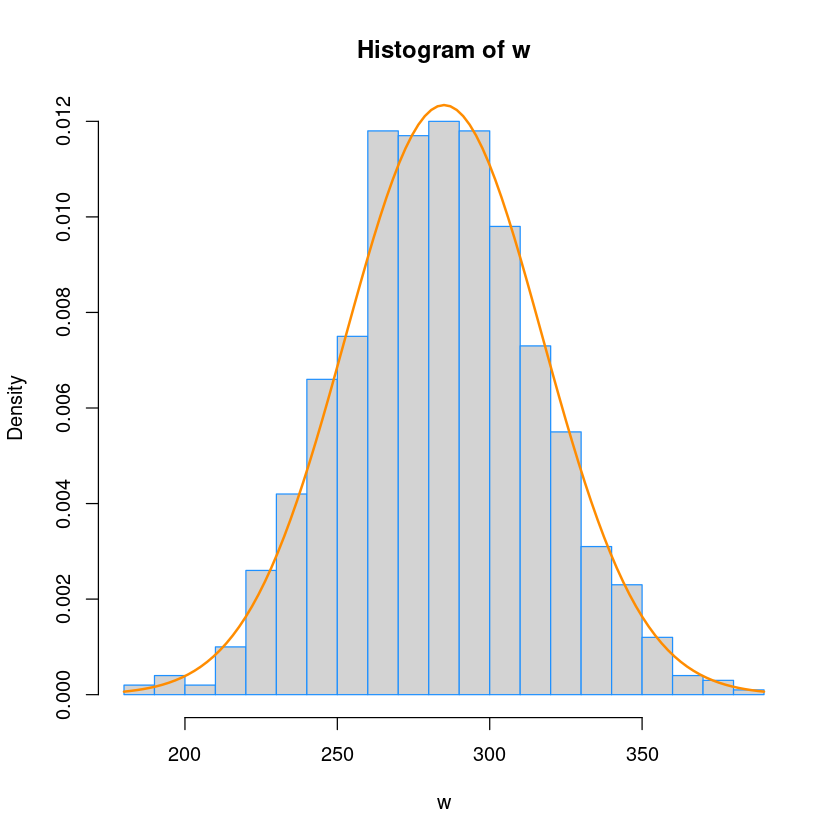

In [138]:
# distribution of w in theory
# if the null hypothesis is true
# then w will follow a normal distrubtion with mean and standard deviation calculated as below
mu <- n1 * (n1 + n2 + 1) / 2
sigma <- sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

# distribution of from simulation, it does match the theory distribution
hist(w, breaks = 20, prob = T, border = "dodgerblue")
# this line show the distribution in theory
curve(dnorm(x, mu, sigma), add = T, col = "darkorange", lwd = 2)

# 3. Non parametric test, Paired test - Wilcoxon Signed Rank test

**Reference**:
- <https://www.youtube.com/watch?v=peF0OXx0G2o&list=PLIeGtxpvyG-IV0Yf8AyeMgmNkpFBxBJlh&index=5>

> **`wilcox.test(x, y, paired = TRUE)`**

### 3.1 Derivation

$H_0: median_1 = median_2$ (There is no difference about CLR of 2 types of ads)  
$H_1: median_1 \ne median_2$ (There is a statistical significant difference between 2 types of ads)  
Significance level: $\alpha = 0.05$


In [24]:
# click through rate (CTR) of 2 different ads on different videos

# Step 1: Place matched sample in 2 columns
clr <- tribble(
    ~ ad1, ~ad2,
    334, 351,
    329, 349,
    311, 277,
    341, 276,
    323, 280,
    329, 341,
    324, 258,
    352, 349,
    342, 338,
    346, 377,
    353, 314,
    318, 331,
    351, 368,
    342, 338,
    355, 313,
    306, 287,
    349, 324,
    353, 293,
    318, 311,
    329, 329,
    300, 314, 
    331, 313,
    298, 309,
    309, 313,
    317, 303
)


In [25]:
(clr <- clr %>% mutate(
    # step 2: in third column, subtract column 2 from 1 from 2 to obtain the differences
    diff = ad1 - ad2,
    # step 3, in column 4, take the absolution value of column 3
    abs_diff = abs(diff)
))

ad1,ad2,diff,abs_diff
<dbl>,<dbl>,<dbl>,<dbl>
334,351,-17,17
329,349,-20,20
311,277,34,34
341,276,65,65
323,280,43,43
329,341,-12,12
324,258,66,66
352,349,3,3
342,338,4,4


In [26]:
# step 4: remove rows having differences of 0
(clr <- clr %>% filter(diff != 0))

ad1,ad2,diff,abs_diff
<dbl>,<dbl>,<dbl>,<dbl>
334,351,-17,17
329,349,-20,20
311,277,34,34
341,276,65,65
323,280,43,43
329,341,-12,12
324,258,66,66
352,349,3,3
342,338,4,4


In [27]:

(clr <- clr %>% mutate(
    # step 5: rank the absolute difference from smallest to highest (use average rank in case tie)
    rank = rank(abs_diff, "average"),
    # step 6: record rows having negative difference as negative rank
    neg_rank = ifelse(diff < 0, rank, 0),
    # step 7: record rows having positive difference as positive rank
    pos_rank = ifelse(diff > 0, rank, 0)
))



ad1,ad2,diff,abs_diff,rank,neg_rank,pos_rank
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
334,351,-17,17,11.5,11.5,0.0
329,349,-20,20,15.0,15.0,0.0
311,277,34,34,18.0,0.0,18.0
341,276,65,65,23.0,0.0,23.0
323,280,43,43,21.0,0.0,21.0
329,341,-12,12,7.0,7.0,0.0
324,258,66,66,24.0,0.0,24.0
352,349,3,3,1.0,0.0,1.0
342,338,4,4,3.0,0.0,3.0


<b style = "color:red"> Notice the correction for $T^+$ because we use normal distribution to estimate the discrete distribution of $T^+$</b>

In [55]:
# step 8: Calculate test statistic T+, the sum of positive rank
# minus 0.5 for correction when using normal distribution to estimate the discrete distribution of T+
T_plus <- sum(clr$pos_rank) 
T_plus_correction <- T_plus - 0.5
c(T_plus = T_plus)

T_plus 
 211.5

$$\mu_{T^+} = \frac{n(n+1)}{4}$$
$$\sigma_{T^+} = \sqrt{\frac{n(n + 1)(2n+1)}{24}}$$

In [56]:
# step 9: Calculate the mean and standard deviation of the distribution of the statistic T+, asumming the null hypothesis H_0 is True
n <- nrow(clr)
mean_T_plus <- n * (n + 1) / 4 
se_T_plus <- sqrt(n * (n + 1) * (2 * n + 1) / 24)

c(sample_size = n, mean = mean_T_plus, sigma = se_T_plus)

sample_size        mean       sigma 
         24         150          35

In [62]:
# step 10: calculate z statistic and p-value
# calculate z using T_plug_correction
z <- (T_plus_correction - mean_T_plus) / se_T_plus
# 2 tail test
p.value <- pnorm(z, lower.tail = F) * 2

c(z = z, p.value = p.value)

z    p.value 
1.74285714 0.08135857

**Conclusion**: p value > 0.05 so we fail to reject $H_0$

### 3.2 Using R

> **`wilcox.test(paired = TRUE)`**

In [67]:
# set correct = T for continuity correction of normal approximation
report <- wilcox.test(clr$ad1, clr$ad2, paired = T, conf.level = 0.95, correct = T) 
report

Warning message in wilcox.test.default(clr$ad1, clr$ad2, paired = T, conf.level = 0.95, :
"cannot compute exact p-value with ties"



	Wilcoxon signed rank test with continuity correction

data:  clr$ad1 and clr$ad2
V = 211.5, p-value = 0.08127
alternative hypothesis: true location shift is not equal to 0


In [71]:
names(report) 

[1] "statistic"   "parameter"   "p.value"     "null.value"  "alternative"
[6] "method"      "data.name"

### 3.3 Simulation

In [97]:
nsims <- 1000
sample_size <- 20
simulated_T_plus <- replicate(nsims, {
    # simulate data from 2 gamma distribution with the same parameters
    sample1 <- rgamma(sample_size, 1, 3)
    sample2 <- rgamma(sample_size, 1, 3)
    sample_data <- tibble(group1 = sample1, group2 = sample2)
    # T plus
    wilcox.test(sample_data$group1, sample_data$group2, paired = TRUE)$statistic %>% unname()
})


In [98]:
mean(simulated_T_plus)

[1] 105.118

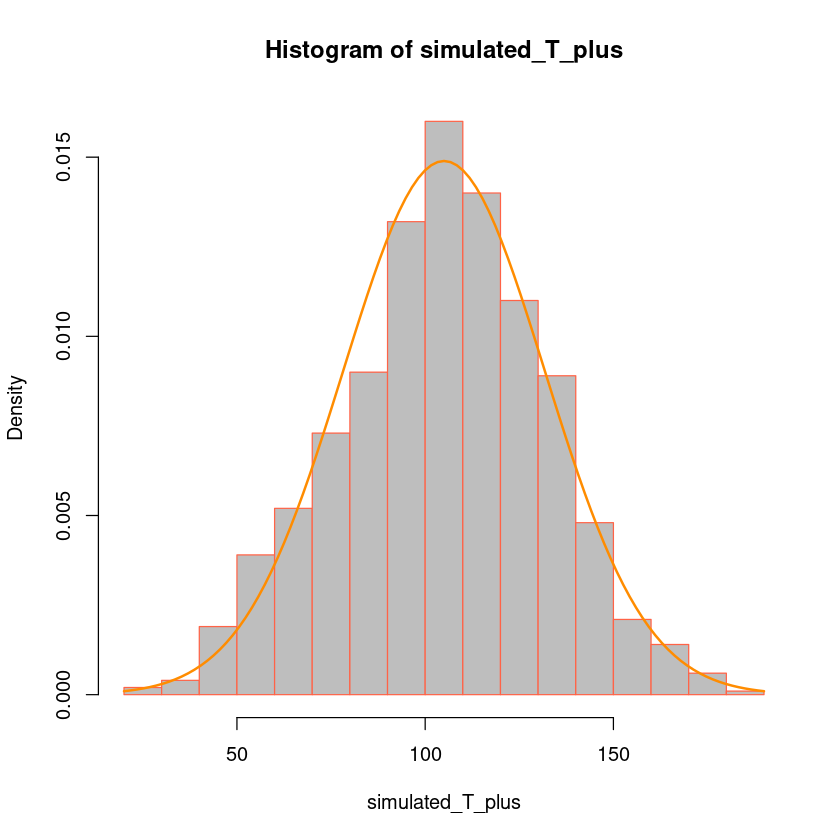

In [104]:
n <- sample_size

# histogram of simulated T+ for 1000 simulations
hist(simulated_T_plus, breaks = 20, prob = T, border = "tomato", col = "grey")
# normal approximation
curve(dnorm(x, mean = n * (n + 1) / 4, sd = sqrt(n * (n + 1) * (2 * n + 1) / 24)), add = T, col = "darkorange", lwd = 2)

# 4. Non parametric version of One-way ANOVA  - Kruskal Wallis Test

**Reference**: <https://www.youtube.com/watch?v=HnNXUO7weQ0&list=PLIeGtxpvyG-IV0Yf8AyeMgmNkpFBxBJlh&index=6>

In one-way ANOVA, the assumption is that each distribution is normally distributed. Kruskal-Wallis Test is the same as one-way ANOVA, but it works for distributions that are not normal

$H_0$: All population are the same  
$H_1$: All population are not the same (there is a statistically significant difference between groups)

<b style = "color:red">NOTE: All Kruskal-Wallis Tests are one-tailed tests because it uses chi squared distribution to obtain the p value</b>

### 4.1 Derivation

In [180]:
scores <- tibble(
    group1 = c(20, 17, 16, 15, 13, 20, 12, 18, 14, 13, 15, 17, 20, 17, 17),
    group2 = c(11, 14, 13, 13, 17, 16, 18, 16, 11, 18, 14, 16, 18, 16, 16),
    group3 = c(17, 23, 15, 15, 16, 16, 19, 17, 23, 22, 17, 17, 20, 23, 21)
)

scores

group1,group2,group3
<dbl>,<dbl>,<dbl>
20,11,17
17,14,23
16,13,15
15,13,15
13,17,16
20,16,16
12,18,19
18,16,17
14,11,23


In [181]:
scores_long <- scores %>% pivot_longer(everything(),
                                      names_to = "group",
                                      values_to = "score",
                                      names_transform = list(group = parse_number))
head(scores_long)

group,score
<dbl>,<dbl>
1,20
2,11
3,17
1,17
2,14
3,23


### 4.2 Using R

> **`kruskal.test()`**

In [182]:
kruskal.test(score ~ group, data = scores_long)


	Kruskal-Wallis rank sum test

data:  score by group
Kruskal-Wallis chi-squared = 8.7336, df = 2, p-value = 0.01269


### 4.3 Simulation

# 5. Non parametric version of Two-way block ANOVA  - Friedman Test

### 5.1 Derivation

In [191]:
# each row is a person
# each column is the rating of a movie (e:g rating[i, j] is the rating of the i person for the j movie)
rating <- tibble(
    person = 1:15,
    movie1 = c(20, 17, 16, 15, 13, 20, 12, 18, 14, 13, 15, 17, 20, 17, 17),
    movie2 = c(11, 14, 13, 13, 17, 16, 18, 16, 11, 18, 14, 16, 18, 16, 16),
    movie3 = c(17, 23, 15, 15, 16, 16, 19, 17, 23, 22, 17, 17, 20, 23, 21),
    movie4 = c(24, 24, 22, 23, 20, 20, 19, 24, 21, 19, 22, 21, 22, 19, 21)
)
rating

person,movie1,movie2,movie3,movie4
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,20,11,17,24
2,17,14,23,24
3,16,13,15,22
4,15,13,15,23
5,13,17,16,20
6,20,16,16,20
7,12,18,19,19
8,18,16,17,24
9,14,11,23,21


In [192]:
rating_long <- rating %>% 
pivot_longer(!person, 
            names_to = "movie",
            values_to = "rating",
            names_transform = list(movie = parse_number))
head(rating_long)

person,movie,rating
<int>,<dbl>,<dbl>
1,1,20
1,2,11
1,3,17
1,4,24
2,1,17
2,2,14


### 5.2 Using R

In [195]:
friedman.test(rating ~ movie | person, data = rating_long)


	Friedman rank sum test

data:  rating and movie and person
Friedman chi-squared = 28.888, df = 3, p-value = 2.364e-06


### 5.3 Simulation

# 6. Spearman Rank correlation

**Reference**: 
- <https://www.youtube.com/watch?v=KJ8NOJe77y8&list=PLIeGtxpvyG-IV0Yf8AyeMgmNkpFBxBJlh&index=8>
- [Comprehensive tutorial on correlation with R](http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r)

Correlation for rank or ordinal data: $r_s$. It is basically the Pearson correlation on rank.  
$H_0: p = 0$  
$H_1: p \ne 0$

## 6.1 Correlation test

>Correlation test is used to evaluate the association between two or more variables.

```r
cor(x, y, method = c("pearson", "kendall", "spearman"))
cor.test(x, y, method=c("pearson", "kendall", "spearman"))
```

## 6.2 Correlation methods

- **pearson**: parametric, make assumption about the linear relationship between 2 variables and the distribution of each variable is normal. If the data is not normally distributed, it is recommended to use the non-parametric correlation
- **spearman**: Spearman’s rho statistic is also used to estimate a rank-based measure of association. This test may be used if the data do not come from a bivariate normal distribution.
- **kendal**:  used to estimate a rank-based measure of association. This test may be used if the data do not necessarily come from a bivariate normal distribution.

### 6.2.1 Pearson correlation (Parametric)

$$r = \frac{\sum{(x-m_x)(y-m_y)}}{\sqrt{\sum{(x-m_x)^2}\sum{(y-m_y)^2}}}$$

In [1]:
cor(mtcars$mpg, mtcars$disp, method = "pearson")

[1] -0.8475514

In [16]:
# equivalent
x <- with(mtcars, mpg - mean(mpg))
y <- with(mtcars, disp - mean(disp))
r <- sum(x * y) / sqrt(sum(x^2) * sum(y^2))
r

[1] -0.8475514

In [17]:
# equivalent
x <- mtcars$mpg
y <- mtcars$disp

cov(x, y) / sqrt(cov(x, x) * cov(y, y))

[1] -0.8475514

#### 6.2.1.1 Assumptions
- Is the covariation linear? Yes, form the plot above, the relationship is linear. In the situation where the scatter plots show curved patterns, we are dealing with nonlinear association between the two variables.

`geom_smooth()` using formula 'y ~ x'



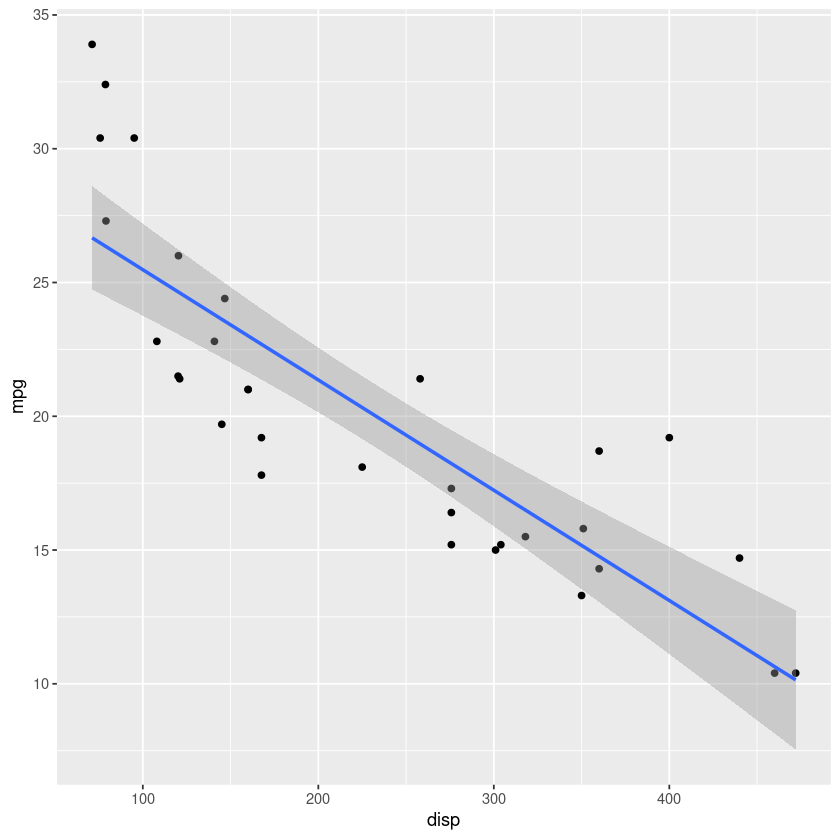

In [18]:
mtcars %>% 
ggplot(aes(disp, mpg)) + 
geom_point() + 
geom_smooth(method = "lm")

- Are the data from each of the 2 variables (x, y) follow a normal distribution? (using Shapiro-Wilk Test, histogram or qqplot)

In [19]:
# the sample size is small so histogram is not useful here
shapiro.test(mtcars$mpg)  # fail to reject H_0 at 0.01 significant level, we assume the normal assumption is not violated
shapiro.test(mtcars$disp) # fail to reject H_0 at 0.01 significant level, we assume the normal assumption is not violated


	Shapiro-Wilk normality test

data:  mtcars$mpg
W = 0.94756, p-value = 0.1229



	Shapiro-Wilk normality test

data:  mtcars$disp
W = 0.92001, p-value = 0.02081


#### 6.2.1.2 Hypothesis testing

Test statistic
$$t = \frac{r}{\sqrt{1-r^2}}\sqrt{n-2}$$
sample from a $t$ distribution with $df = n - 2$ degree of freedom

In [13]:
cor.test(mtcars$mpg, mtcars$disp, method = "pearson")


	Pearson's product-moment correlation

data:  mtcars$mpg and mtcars$disp
t = -8.7472, df = 30, p-value = 9.38e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9233594 -0.7081376
sample estimates:
       cor 
-0.8475514 


p value < 0.01, we reject $H_0$, concludes that the correlation is significant

### 6.2.2 Spearman Rank correlation (Non-parametric)

$$rho = \frac{\sum(x' - m_{x'})(y'_i - m_{y'})}{\sqrt{\sum(x' - m_{x'})^2 \sum(y' - m_{y'})^2}}$$
where $x' = rank(x)$, $y' = rank(y)$

In [11]:
cor(mtcars$mpg, mtcars$disp, method = "spearman")

[1] -0.9088824

In [21]:
# equivalent
with(mtcars, cor(rank(mpg), rank(disp), method = "pearson"))

[1] -0.9088824

#### 6.2.2.1 Hypothesis testing

In [22]:
cor.test(mtcars$mpg, mtcars$disp, method = "spearman")

Warning message in cor.test.default(mtcars$mpg, mtcars$disp, method = "spearman"):
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  mtcars$mpg and mtcars$disp
S = 10415, p-value = 6.37e-13
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.9088824 


p value < 0.01, so we reject $H_0$, concludes that the correlation is significant

### 6.2.3 Kendal Rank correlation (Parametric)

In [10]:
cor(mtcars$mpg, mtcars$disp, method = "kendall")

[1] -0.7681311

## 6.3 Interpretation

Correlation coefficient is comprised between -1 and 1:
- -1 indicates a strong **negative** correlation : this means that every time x increases, y decreases (left panel figure)
- 0 means that there is no **association** between the two variables (x and y) (middle panel figure)
- 1 indicates a strong **positive** correlation : this means that y increases with x (right panel figure)

# 7. Compare the medians or 2 or more groups - Mood's Median Test

Think of this as non-parametric one-way ANOVA  
<b style = "color:red">NOTE: Kruskal-Wallis Test is considered better than Mood's median Test, because it has more statistical power, because it considers the ranks of observations, not just the sign</b>

**Reference**:
- <https://www.youtube.com/watch?v=tWcEZSCNEuI&list=PLIeGtxpvyG-IV0Yf8AyeMgmNkpFBxBJlh&index=9>

It's based on the:
- Signed Test
- Chi-squared Test

> **`mood.test`**